### Setup process

In [1]:
# get all data
!git clone https://github.com/fbientrigo/machine-learning-physics

Cloning into 'machine-learning-physics'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 622 (delta 76), reused 160 (delta 51), pack-reused 425
Receiving objects: 100% (622/622), 60.29 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Updating files: 100% (302/302), done.


In [ ]:
!pip uninstall -y deepql

Found existing installation: deepql 0.1.0
Uninstalling deepql-0.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/deepql.egg-link
Proceed (Y/n)? Y
  Successfully uninstalled deepql-0.1.0


In [2]:
# install library
%cd /content/machine-learning-physics/
!sudo python3 -m pip install -e deepql

# solves error adding to path the folder
import sys 
sys.path.append(r'/content/machine-learning-physics/deepql')

# get to main development zone
%cd /content/machine-learning-physics/3_better_net
!pwd

/content/machine-learning-physics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/machine-learning-physics/deepql
  Preparing metadata (setup.py) ... done
  Running setup.py develop for deepql
/content/machine-learning-physics/3_better_net
/content/machine-learning-physics/3_better_net


In [ ]:
!pip show deepql

Name: deepql
Version: 0.1.0
Summary: A package for the physics inverse problem of finding the force giving the trajectory
Home-page: 
Author: Fabian Trigo
Author-email: fbientrigo@gmail.com
License: 
Location: /content/machine-learning-physics/deepql
Editable project location: /content/machine-learning-physics/deepql
Requires: numpy, pandas
Required-by: 


# Code

In [3]:
import deepql
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Data Loading
data = pd.read_csv("gen_data/heun_c1_u021.csv", index_col=0)
print(len(data))
# limits of data
umax = data.u.max()
umin = data.u.min()

print(f"min: {umin}, max: {umax}")
# important parameters from data
dt = data.phi[1] - data.phi[0]
print(f"dt: {dt}")

# ammount of points for the force function
# more points -> more training
N_ff = 200
df = deepql.separate_data(df=data, run_length=150,
     position='u', velocity='udot')

print(len(df))
df.head()


3000
min: 0.0480733277999466, max: 0.2101430908430522
dt: 0.05
2849


,x_initial,v_initial,x_step10,v_step10,x_step20,v_step20,x_step30,v_step30,x_step40,v_step40,...,x_step110,v_step110,x_step120,v_step120,x_step130,v_step130,x_step140,v_step140,x_step150,v_step150
0,0.209908,-0.003666,0.199147,-0.038578,0.172721,-0.065125,0.136408,-0.077315,0.098304,-0.072077,...,0.176587,0.062585,0.201367,0.034662,0.210003,-0.000767,0.200629,-0.036032,0.175269,-0.063491
1,0.209634,-0.007323,0.197138,-0.041725,0.169414,-0.067068,0.132533,-0.077595,0.094735,-0.070589,...,0.179661,0.060327,0.203018,0.031337,0.209873,-0.004432,0.198746,-0.039247,0.172041,-0.065549
2,0.209176,-0.010965,0.194974,-0.044780,0.166014,-0.068860,0.128649,-0.077695,0.091245,-0.068935,...,0.182619,0.057933,0.204501,0.027943,0.209560,-0.008087,0.196704,-0.042376,0.168714,-0.067461
3,0.208537,-0.014583,0.192660,-0.047736,0.162528,-0.070497,0.124763,-0.077617,0.087842,-0.067118,...,0.185455,0.055411,0.205813,0.024487,0.209065,-0.011725,0.194508,-0.045411,0.165295,-0.069221
4,0.207718,-0.018168,0.190201,-0.050587,0.158964,-0.071974,0.120887,-0.077359,0.084533,-0.065142,...,0.188161,0.052766,0.206950,0.020978,0.208388,-0.015337,0.192163,-0.048346,0.161792,-0.070825


In [5]:
!cd model && ls

0605_heunc1_pp_npp_epoch1000.pt  0605_heunc1_pp_npp_epoch3100.pt
0605_heunc1_pp_npp_epoch1500.pt  0605_heunc1_pp_npp_epoch500.pt
0605_heunc1_pp_npp_epoch2300.pt  heun_pp


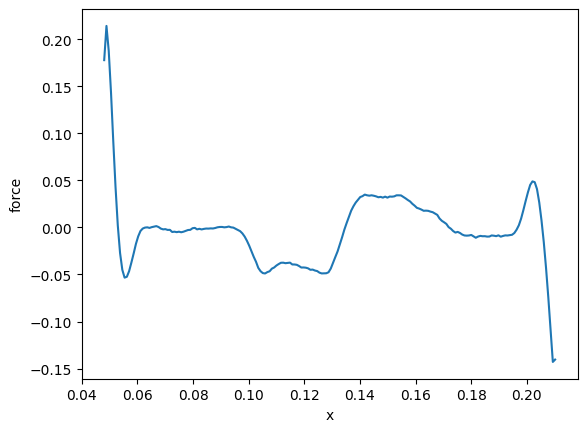

In [6]:
# Model
model = torch.load("./model/0605_heunc1_pp_npp_epoch3100.pt")
model.plot_parameters()

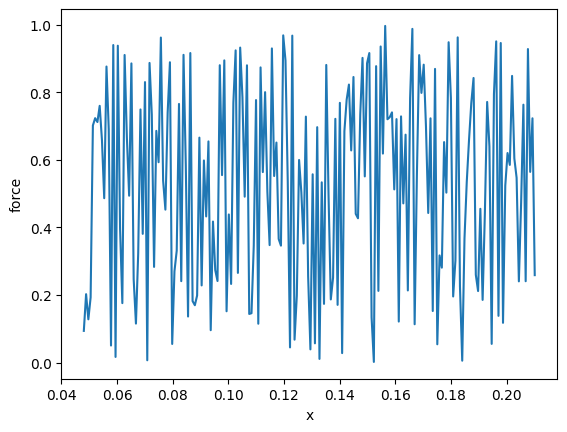

In [ ]:
# Other Model Easier to train

post_processing_epsilon = df.std().x_step150
post_processing_mean = df.mean().x_step150

model = deepql.diffnet.diffNet(
    depth=150, dt=dt, N=N_ff, lower_limit=umin, upper_limit=umax,
    post_process=False, 
    force_type='position', debug=False
)

model.plot_parameters()

In [7]:
# Hyperparameters
smooth_rate = 0.05
targets_rate = 1
name = "0605_heunc1_pp"

batch_size = 10
shuffle_batch = True

# Learning rate
learning_rate = 0.3

# Define loss function and optimizer
L2_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.001, total_iters=100)


# initializing data
my_dataset = deepql.MyDataset(df, step_size=150)
my_dataloader = deepql.DataLoader(my_dataset, 
    batch_size=batch_size, shuffle=shuffle_batch)


running_loss = 0

In [ ]:
# another proposed scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 50,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate

In [8]:
loss_array = []

In [10]:
# Define number of epochs
num_epochs = 500

In [ ]:
#used for graphs
max_i = len(my_dataloader)
model.train(); # switch a modo entranmiento

# Iterate through epochs
base_epoch = 3100


# Training
for epoch in range(base_epoch, base_epoch+num_epochs+1):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        
        # Compute loss
        L2_computed_loss = L2_loss(outputs, targets)
        loss = smooth_rate * deepql.diffnet.smooth_loss(list(model.parameters())[0]) +\
            targets_rate * L2_computed_loss

        loss_array.append(loss.item())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # scheduler workings
    scheduler.step()


    if epoch % 100 == 10:
        # saving the model
        torch.save(model, f"./model/{name}_epoch{epoch}.pt")
        
        #ploting
        model.plot_parameters()
        plt.show()
        # plt.savefig(f"./evolution_force/{name}_epoch_{epoch}_loss_{running_loss :.2f}.png")


# finish training
#torch.save(model, f"./model/{name}_epoch{epoch}.pt")
print('Finished training')



In [12]:
epoch

3264

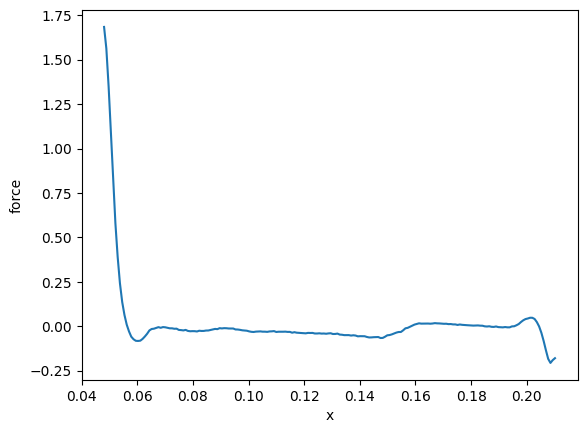

In [15]:
model.plot_parameters()
plt.show()

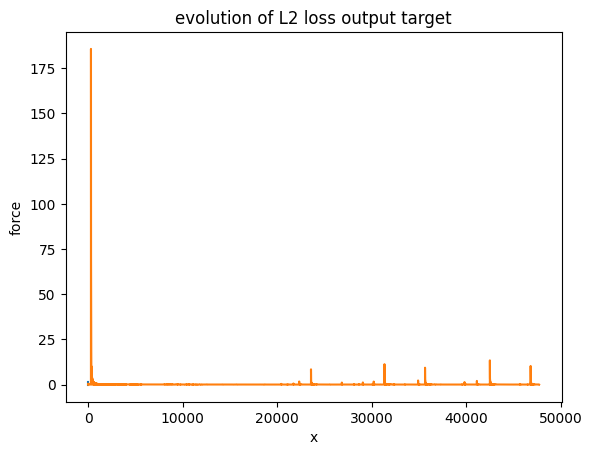

In [14]:
# plot loss
plt.plot(loss_array)
plt.title("evolution of L2 loss output target")
plt.show()

3099

In [ ]:
total_epochs = 500 + 500 + 500

In [13]:
# saving the model
torch.save(model, f"./model/{name}_npp_epoch{epoch+1}.pt")